In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
!unzip -q database4.zip
!ls

database4  database4.zip  sample_data


In [11]:
!ls database4

NO_SRB	SRB


In [12]:
image_size = (180, 180)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "database4",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1356 files belonging to 2 classes.
Using 1085 files for training.
Using 271 files for validation.


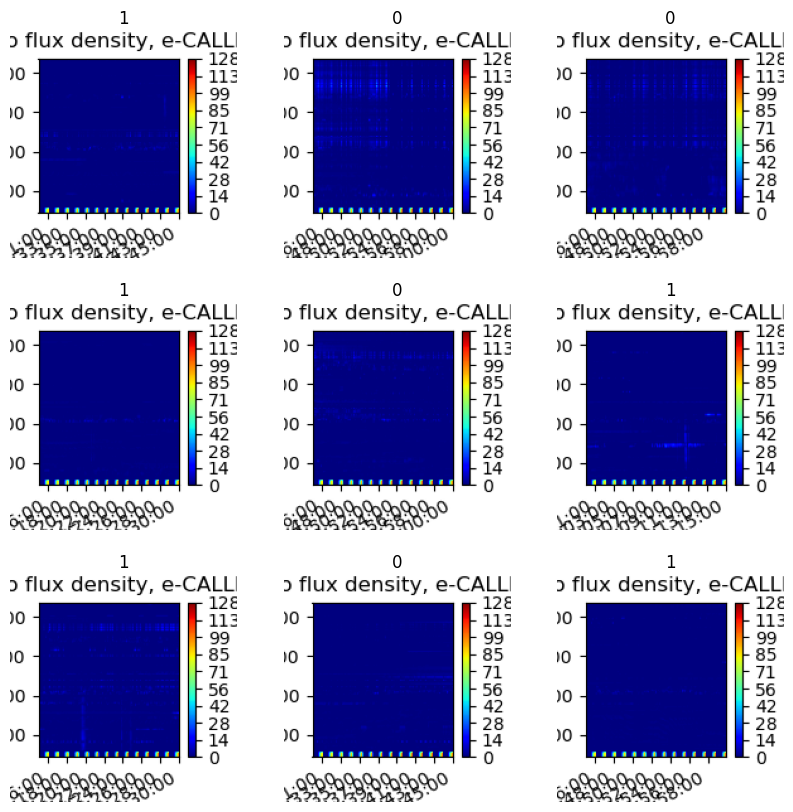

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
    ]
)

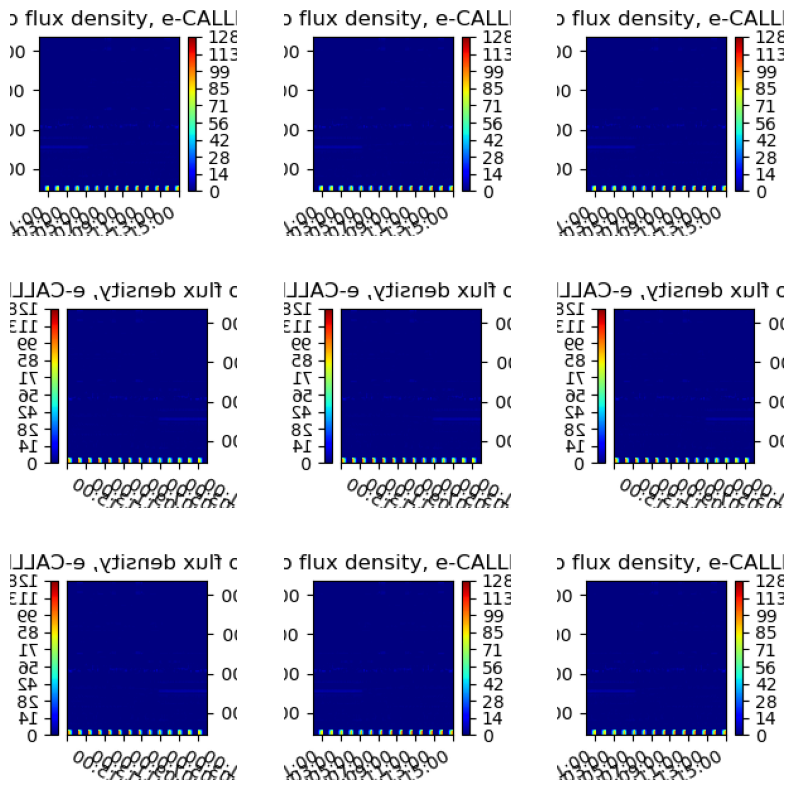

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [16]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [17]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

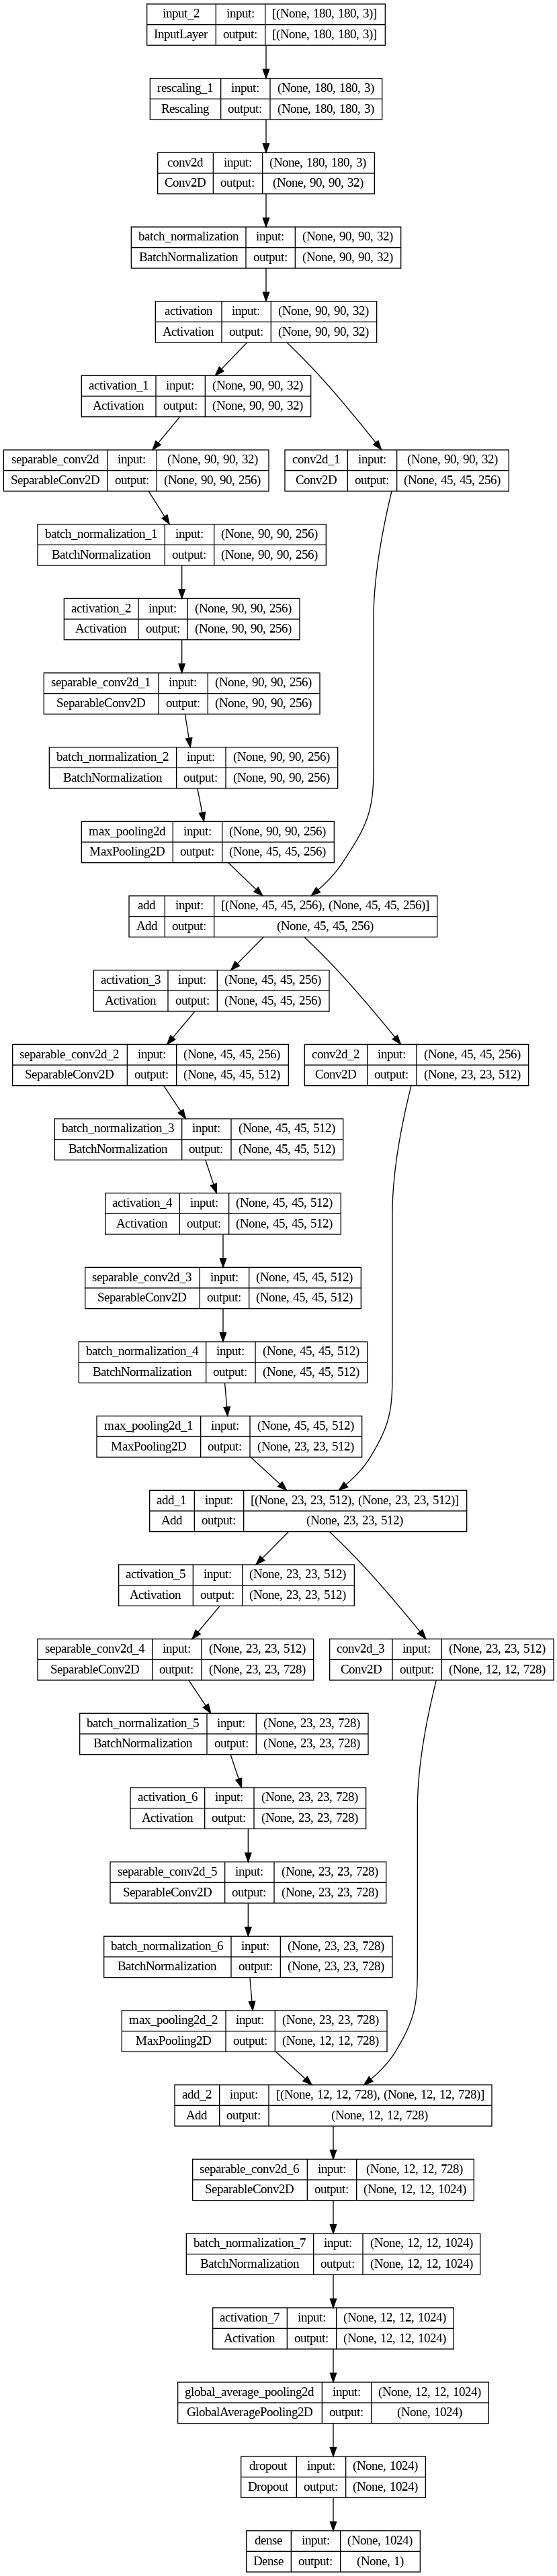

In [18]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [19]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
34/34 [==============================] - 39s 462ms/step - loss: 0.7156 - accuracy: 0.5438 - val_loss: 0.7064 - val_accuracy: 0.4539
Epoch 2/25
34/34 [==============================] - 10s 300ms/step - loss: 0.6682 - accuracy: 0.6092 - val_loss: 0.6902 - val_accuracy: 0.5461
Epoch 3/25
34/34 [==============================] - 11s 321ms/step - loss: 0.5902 - accuracy: 0.6747 - val_loss: 0.6909 - val_accuracy: 0.5461
Epoch 4/25
34/34 [==============================] - 11s 309ms/step - loss: 0.5380 - accuracy: 0.7346 - val_loss: 0.7438 - val_accuracy: 0.5461
Epoch 5/25
34/34 [==============================] - 11s 319ms/step - loss: 0.4053 - accuracy: 0.8488 - val_loss: 0.8100 - val_accuracy: 0.5461
Epoch 6/25
34/34 [==============================] - 11s 321ms/step - loss: 0.3909 - accuracy: 0.8406 - val_loss: 0.9975 - val_accuracy: 0.5461
Epoch 7/25
34/34 [==============================] - 11s 314ms/step - loss: 0.3469 - accuracy: 0.8719 - val_loss: 1.1064 - val_accuracy: 0.5461

In [20]:
img = keras.utils.load_img(
    "database4/SRB/HUMAIN_20220408_151500_59.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% NO SRB and {100 * score:.2f}% SRB.")

1/1 [==============================] - 1s 560ms/step
This image is 0.00% NO SRB and 100.00% SRB.


In [21]:
img = keras.utils.load_img(
    "database4/NO_SRB/HUMAIN_20210701_123000_59.png", target_size=image_size
)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% NO SRB and {100 * score:.2f}% SRB.")

1/1 [==============================] - 0s 20ms/step
This image is 93.50% NO SRB and 6.50% SRB.
